In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [76]:
grip_thinning = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono BICC Work/Paleochrono BICC Experiment/BICC2025/GRIP/thinning.txt', sep='\t', comment = '#')
ngrip_thinning = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono BICC Work/Paleochrono BICC Experiment/BICC2025/NGRIP/thinning.txt', sep='\t', comment = '#')

load_gicc05 = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/Chronologies/GICC05_time_scale.tab', sep='\t', comment = '#', skiprows=40)

grip_accumulation = pd.DataFrame()
#take the thickness of each year first
grip_accumulation['thick'] = load_gicc05['Depth ice/snow [m] (GRIP)'].diff() # Calculate annual layer thickness
grip_accumulation['depth']= load_gicc05['Depth ice/snow [m] (GRIP)'] # Depth in meters
grip_accumulation.dropna(inplace=True)  # Remove NaN values resulting from diff()

grip_accumulation = grip_accumulation.dropna(subset=['thick']) # Ensure no NaN values in 'thick' column

In [77]:
load_gicc05 = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/Chronologies/GICC05_time_scale.tab', sep='\t', comment = '#', skiprows=40)
load_gicc05['Depth ice/snow [m] (GRIP)'].max()

1624.27

Text(0.5, 1.0, 'GRIP Accumulation Rate vs Depth')

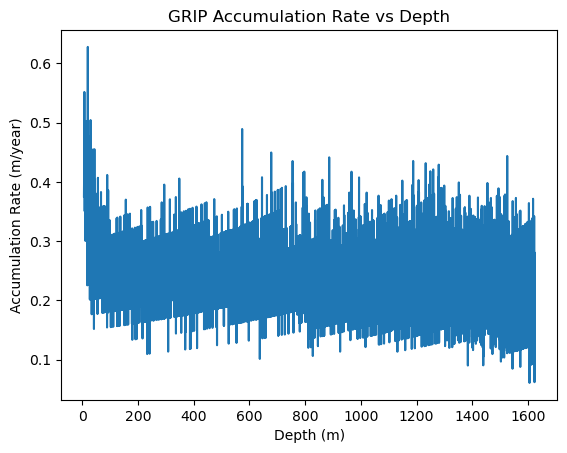

In [78]:
# acc = thickness / thinning factor
grip_accumulation['thinning'] = np.interp(grip_accumulation['depth'], grip_thinning['depth'], grip_thinning['thinning']) # Interpolate thinning factors to match depths

grip_accumulation['accumulation'] = grip_accumulation['thick'] / grip_accumulation['thinning'] # Calculate accumulation rate

plt.plot(grip_accumulation['depth'], grip_accumulation['accumulation']) # Plot accumulation rate vs depth
plt.xlabel('Depth (m)')
plt.ylabel('Accumulation Rate (m/year)')
plt.title('GRIP Accumulation Rate vs Depth')



In [79]:
ngrip_grip_ties = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono BICC Work/Paleochrono BICC Experiment/BICC2025/NGRIP-GRIP/iceice_synchro_horizons.txt', sep='\t', comment = '#', skiprows=1, names=['NGRIP', 'GRIP', "unc"])
ngrip_grip_ties = ngrip_grip_ties.where(ngrip_grip_ties['GRIP'] > grip_accumulation['depth'].max()).dropna() # Drop rows where GRIP is not greater than max depth

ngrip_grip_ties = ngrip_grip_ties.where(ngrip_grip_ties['NGRIP'] < load_gicc05['Depth ice/snow [m] (NGRIP2)'].max()).dropna() # Drop rows where GRIP is not greater than max depth

#get associated NGRIP ages with GICC05
#NGRIP1 max is 1371 so this is all NGRIP2.
gicc05 = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/Chronologies/GICC05_time_scale.tab', sep='\t', comment = '#', skiprows=40)

gicc05.dropna(inplace=True, subset=['Depth ice/snow [m] (NGRIP2)', 'Age [a] (b2k)']) # Ensure no NaN values in relevant columns
gicc05_interp = gicc05[['Age [a] (b2k)', 'Depth ice/snow [m] (NGRIP2)']]

ngrip_grip_ties['GICC05_age'] = np.interp(ngrip_grip_ties['NGRIP'], gicc05_interp['Depth ice/snow [m] (NGRIP2)'], gicc05_interp['Age [a] (b2k)'])

ngrip_grip_ties['time_diff'] = ngrip_grip_ties['GICC05_age'].diff().abs() # Calculate time differences between consecutive ties
ngrip_grip_ties['depth_diff'] = ngrip_grip_ties['GRIP'].diff().abs() # Calculate depth differences between consecutive ties

ngrip_grip_ties['annual_thickness'] = ngrip_grip_ties['depth_diff'] / ngrip_grip_ties['time_diff'] # Calculate annual layer thickness
ngrip_grip_ties = ngrip_grip_ties.dropna(subset=['annual_thickness']) # Ensure no NaN values in 'annual_thickness' column

grip_accumulation2 = ngrip_grip_ties[['annual_thickness']].copy(deep=True)
grip_accumulation2['depth'] = ngrip_grip_ties['GRIP'] # Depth in meters
grip_accumulation2['thinning'] = np.interp(grip_accumulation2['depth'], grip_thinning['depth'], grip_thinning['thinning']) # Interpolate thinning factors to match depths

grip_accumulation2['deporate'] = grip_accumulation2['annual_thickness'] / grip_accumulation2['thinning'] # Calculate accumulation rate
grip_accumulation_export2 = grip_accumulation2[['depth', 'deporate']]
grip_accumulation_export2['rel_unc'] = grip_accumulation_export2['deporate'] * 0.15
grip_accumulation_export2['comment'] = np.nan

grip_accumulation_export2

/var/folders/cd/1mh45k3j19g5g_kxkz_17xvc0000gn/T/ipykernel_19230/4157501573.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grip_accumulation_export2['rel_unc'] = grip_accumulation_export2['deporate'] * 0.15


,depth,deporate,rel_unc,comment
602,1625.651,0.114886,0.017233,NaN
603,1625.816,0.086915,0.013037,NaN
604,1626.516,0.116107,0.017416,NaN
605,1627.543,0.097081,0.014562,NaN
606,1628.029,0.121128,0.018169,NaN
...,...,...,...,...
967,2475.174,0.226204,0.033931,NaN
968,2476.001,0.237788,0.035668,NaN
969,2478.222,0.120140,0.018021,NaN
970,2478.420,0.111854,0.016778,NaN


In [80]:
grip_accumulation.rename(columns={
    'accumulation': 'deporate'
}, inplace=True)

grip_accumulation['rel_unc'] = grip_accumulation['deporate'] * 0.15  # 15% relative uncertainty

grip_accumulation['comment'] = np.nan

grip_accumulation_export = grip_accumulation[['depth', 'deporate', 'rel_unc', 'comment']]

grip_accumulation_export_3 = pd.concat([grip_accumulation_export, grip_accumulation_export2], ignore_index=True)

grip_accumulation_export_3

,depth,deporate,rel_unc,comment
0,5.800,0.375773,0.056366,NaN
1,6.200,0.400860,0.060129,NaN
2,6.625,0.425068,0.063760,NaN
3,7.175,0.551878,0.082782,NaN
4,7.725,0.550338,0.082551,NaN
...,...,...,...,...
12048,2475.174,0.226204,0.033931,NaN
12049,2476.001,0.237788,0.035668,NaN
12050,2478.222,0.120140,0.018021,NaN
12051,2478.420,0.111854,0.016778,NaN


In [82]:
grip_accumulation_export_3.to_csv('/Users/quinnmackay/Desktop/temp/deporate.txt', sep='\t', index=False)